# Oefening deel 4: Energiestromen Visualiseren met Sankey Diagram

> **Workshop Atic 4D**  
> **Lesgevers:** Lien De Backer & Jakob De Vreese

In deze oefening visualiseren we de energiestromen van het gebouw Dunant 1 aan de hand van een **Sankey diagram**. Dit type diagram is perfect om energiebalansen overzichtelijk weer te geven.

## 🎯 Leerdoelen

Na deze oefening kun je:
- Sankey diagrammen maken met Matplotlib en Plotly
- Energiestromen logisch structureren (input → conversie → output → verbruik)
- Energiebalansen opstellen en valideren
- Verliezen en rendementen visualiseren
- Interactieve visualisaties maken voor rapportage

## 📊 Datasets

We gebruiken volgende datasets (data van 2020-2025):
1. **Gasteller** - gasverbruik voor gasketel (kWh)
2. **Calorieteller gasketel** - warmte-opwekking gasketel (kWh)
3. **Calorieteller injectie gasketel** - Injectie vna ketel in lage-temperatuur circuit (kWh)
4. **Elektriciteit warmtepomp** - elektrisch verbruik WP (kWh)
5. **Calorieteller warmtepomp** - warmte/koude opwekking WP (kWh)
6. **BEO-veld** - energie naar/van bodem (kWh)
7. **Calorieteller afgifte** - warmte naar verschillende systemen:
   - Vloerverwarming
   - Luchtgroepen
   - Radiatoren (BEO)

## 🏗️ Structuur

1. Packages importeren
2. Data inladen en opschonen
3. Basis Sankey diagram (eenvoudig voorbeeld)
4. Energiebalans berekenen voor het gebouw
5. Volledig Sankey diagram met alle energiestromen
6. Interactief Sankey diagram met Plotly
7. Tijdsafhankelijke analyse (maandelijks/jaarlijks)

## 1️⃣ Packages Importeren

In [2]:
# ============================================
# PACKAGES IMPORTEREN
# ============================================

# Numerieke berekeningen en data
import numpy as np
import pandas as pd

# Visualisatie - basis
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.sankey import Sankey

# Visualisatie - interactief
import plotly.graph_objects as go
import plotly.express as px

# Configuratie
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Alle packages succesvol geladen!")

✓ Alle packages succesvol geladen!


## 2️⃣ Hulpfuncties voor Data Inladen

We hergebruiken de hulpfunctie uit de vorige oefeningen om GBS-export bestanden in te laden.

In [4]:
def load_gbs_export(filepath, energy_cols_keywords, date_format='%m/%d/%y'):
    """
    Laad een tab-gescheiden GBS export bestand in.
    
    Parameters:
    -----------
    filepath : str
        Pad naar het bestand
    energy_cols_keywords : dict
        Dict met {nieuwe_naam: zoekterm} voor kolommen
    date_format : str
        Format van de datum in het bestand
        
    Returns:
    --------
    pd.DataFrame met DatetimeIndex en hernoemde kolommen
    """
    # Inladen
    df = pd.read_csv(filepath, sep='\t')
    
    # Verwijder Unnamed kolommen
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    
    # Zoek en hernoem energie kolommen
    rename_dict = {}
    for new_name, keyword in energy_cols_keywords.items():
        matching_cols = [c for c in df.columns if keyword.lower() in c.lower()]
        if matching_cols:
            rename_dict[matching_cols[0]] = new_name
    
    df = df.rename(columns=rename_dict)
    
    # Vind Time kolom
    time_col = 'Time' if 'Time' in df.columns else [c for c in df.columns if 'time' in c.lower()][0]
    
    # Parse datum (alleen deel voor komma)
    df['date'] = (
        df[time_col]
        .astype(str)
        .str.split(',', n=1)
        .str[0]
        .str.strip()
    )
    
    df['date'] = pd.to_datetime(df['date'], format=date_format, errors='coerce')
    df = df.dropna(subset=['date'])
    
    # Zet index en drop originele time kolom
    df = df.set_index('date').drop(columns=[time_col])
    
    # Selecteer alleen de hernoemde kolommen
    valid_cols = [col for col in energy_cols_keywords.keys() if col in df.columns]
    
    return df[valid_cols]

print("✓ Hulpfunctie gedefinieerd")

✓ Hulpfunctie gedefinieerd


## 3️⃣ Data Inladen

We laden alle benodigde datasets in. Voor deze oefening focussen we op **jaarlijkse totalen** om de energiestromen overzichtelijk te houden.

In [5]:
# 3.1 Gasteller (primaire energie-input)
gasteller = pd.read_csv('data/gasteller.txt', sep='\t', header=0)
gasteller = gasteller.iloc[:,:-1] # Laatse kolom laten vallen
gasteller.columns = ['datum', 'gastellerstand'] # Kolommen hernoemen
gasteller['datum'] = pd.to_datetime(
    gasteller['datum'].str.split(',').str[0],
    format='%m/%d/%y',
    errors='coerce'
) # Omzetten naar datetime
gasteller = gasteller.set_index('datum').sort_index() # Datum als index instellen
gasteller = gasteller / 100  # Correctie voor komma-fout

print(gasteller.head())

gasverbruik = gasteller.diff().rename(columns={'gastellerstand': 'gasverbruik'})
gasverbruik = gasverbruik.clip(lower=0)  # Negatieve waarden op 0
gasverbruik = gasverbruik[gasverbruik < 1000]  # Verwijder uitschieters
gasverbruik_kwh = gasverbruik * 11.4  # m³ → kWh

print(f"✓ Gasteller: {len(gasverbruik_kwh)} dagen")

            gastellerstand
datum                     
2020-02-01             0.0
2020-02-02             0.0
2020-02-03             0.0
2020-02-04             0.0
2020-02-05             0.0
✓ Gasteller: 2030 dagen


<Axes: xlabel='datum'>

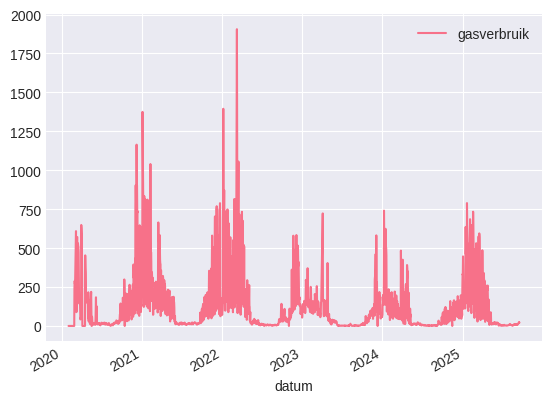

In [6]:
gasverbruik_kwh.plot()

In [7]:
# 3.2 Calorieteller gasketel (warmte-output gasketel)
cal_gasketel = load_gbs_export(
    'data/calorieteller_gasketel.txt',
    energy_cols_keywords={'gasketel_warm': 'warm'}
)
cal_gasketel_dag = cal_gasketel.diff() / 1000  # Wh → kWh
cal_gasketel_dag = cal_gasketel_dag.clip(lower=0)

print(f"✓ Calorieteller gasketel: {len(cal_gasketel_dag)} dagen")
print(cal_gasketel.head())

✓ Calorieteller gasketel: 1915 dagen
            gasketel_warm
date                     
2020-05-29      7922072.0
2020-05-30      7922072.0
2020-05-31      7922177.0
2020-06-01      7922177.0
2020-06-02      7922177.0


<Axes: xlabel='date'>

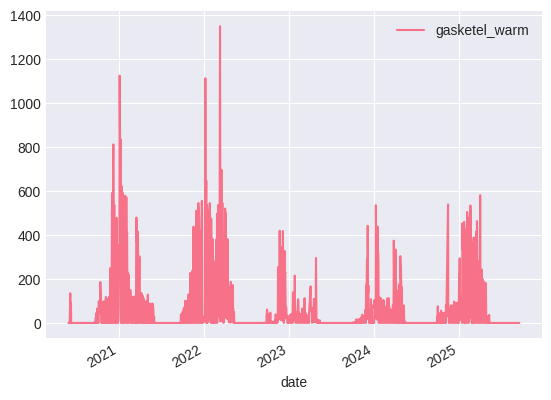

In [8]:
cal_gasketel_dag.plot()

In [9]:
# 3.3 Elektriciteit warmtepomp (primaire energie-input)
elek = pd.read_csv('data/elek_WP_1102.csv', parse_dates=['datum'], index_col='datum')
elek.columns = elek.columns.str.replace('\ufeff', '', regex=False).str.strip()
elek = elek.sort_index()

print(f"✓ Elektriciteit WP: {len(elek)} metingen")
print(elek.head())

✓ Elektriciteit WP: 9 metingen
            teller_30P1
datum                  
2020-02-26       1259.3
2022-03-23      11454.0
2022-07-05      11488.0
2022-11-21      12191.0
2023-01-18      14303.0


In [10]:
# 3.4 Calorieteller warmtepomp (warmte/koude output WP)
cal_wp = load_gbs_export(
    'data/calorieteller_wp.txt',
    energy_cols_keywords={
        'wp_warm': 'energieverbruik warm'
    }
)
cal_wp_dag = cal_wp.diff().clip(lower=0)

print(f"✓ Calorieteller WP: {len(cal_wp_dag)} dagen")
print(cal_wp.head())

✓ Calorieteller WP: 1899 dagen
            wp_warm
date               
2020-05-29   3195.0
2020-05-30   3222.0
2020-05-31   3237.0
2020-06-01   3262.0
2020-06-02   3288.0


<Axes: xlabel='date'>

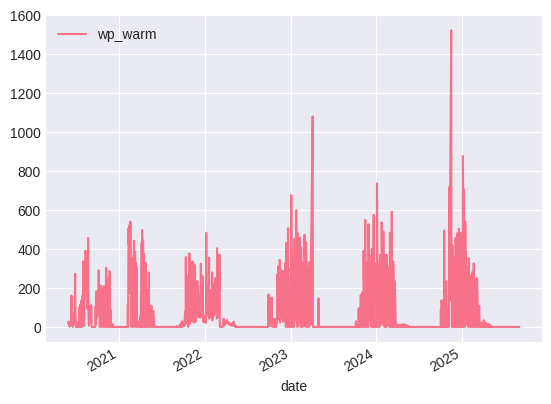

In [11]:
cal_wp_dag.plot()

In [12]:
# 3.5 BEO-veld (energie naar/van bodem)
cal_beo = load_gbs_export(
    'data/calorieteller_beo.txt',
    energy_cols_keywords={
        'beo_afname': 'koud',
        'beo_injectie': 'warm'
    }
)

# Converteer van MWh naar kWh indien nodig
if cal_beo['beo_afname'].max() < 1000:
    cal_beo['beo_afname'] *= 1000
    cal_beo['beo_injectie'] *= 1000

cal_beo_dag = cal_beo.diff().clip(lower=0)

print(f"✓ BEO-veld: {len(cal_beo_dag)} dagen")
print(cal_beo.head())

✓ BEO-veld: 1899 dagen
            beo_afname  beo_injectie
date                                
2020-05-29       320.0      970.0000
2020-05-30       350.0      980.0000
2020-05-31       420.0      980.0000
2020-06-01       440.0      980.0000
2020-06-02       460.0      989.9999


<Axes: xlabel='date'>

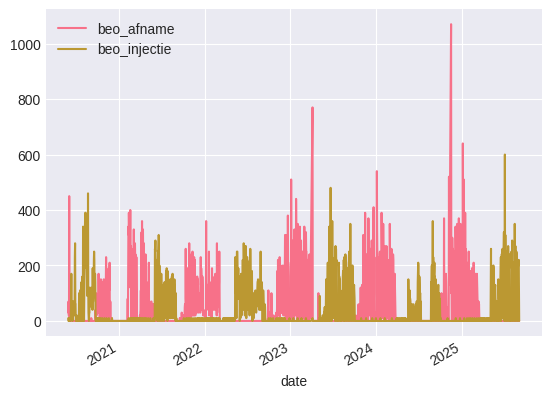

In [13]:
cal_beo_dag.plot()

In [14]:
cal_inj = load_gbs_export(
    'data/calorieteller_injectie_LT.txt',
    energy_cols_keywords={'injectie': 'warm'}
)
cal_inj_dag = cal_inj.diff().clip(lower=0)
print(cal_inj)

            injectie
date                
2020-05-29    3967.0
2020-05-30    3967.0
2020-05-31    3967.0
2020-06-01    3967.0
2020-06-02    3967.0
...              ...
2025-08-28   95477.0
2025-08-29   95477.0
2025-08-30   95477.0
2025-08-31   95477.0
2025-09-01   95477.0

[1899 rows x 1 columns]


<Axes: xlabel='date'>

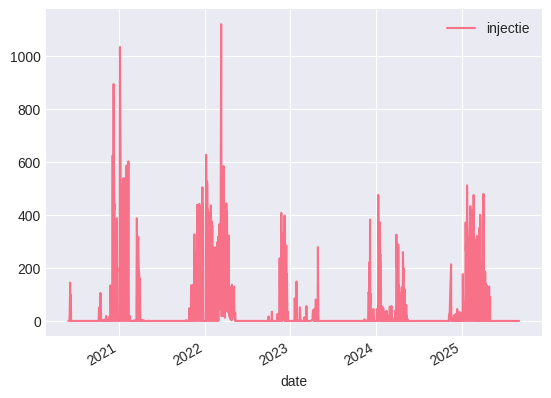

In [15]:
cal_inj_dag.plot()

In [16]:
# 3.6 Afgiftesystemen (waar gaat de warmte naartoe?)
cal_vloer = load_gbs_export(
    'data/calorieteller_vloerverwarming.txt',
    energy_cols_keywords={'vloerverw_warm': 'warm', 'vloerverw_koud': 'koud'}
)
print(cal_vloer.head())
cal_vloer_dag = cal_vloer.diff().clip(lower=0)

cal_lucht = load_gbs_export(
    'data/calorieteller_luchtgroepen.txt',
    energy_cols_keywords={'luchtgroep_warm': 'warm', 'luchtgroep_koud': 'koud'}
)
print(cal_lucht.head())
cal_lucht_dag = cal_lucht.diff().clip(lower=0)

print(f"✓ Afgiftesystemen ingeladen")

            vloerverw_warm  vloerverw_koud
date                                      
2020-05-29          5982.0             4.0
2020-05-30          5982.0             4.0
2020-05-31          5986.0             4.0
2020-06-01          5988.0             4.0
2020-06-02          5989.0             4.0
            luchtgroep_warm  luchtgroep_koud
date                                        
2020-05-29             5.76             0.05
2020-05-30             5.79             0.05
2020-05-31             5.84             0.06
2020-06-01             5.88             0.06
2020-06-02             5.93             0.06
✓ Afgiftesystemen ingeladen


<Axes: xlabel='date'>

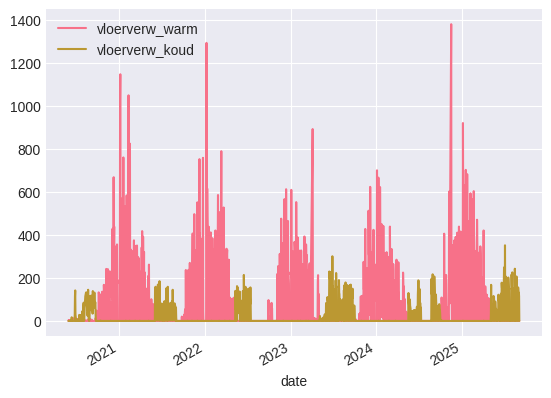

In [17]:
cal_vloer_dag.plot()

<Axes: xlabel='date'>

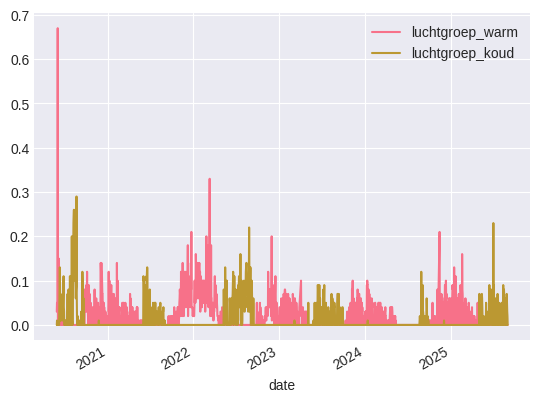

In [18]:
cal_lucht_dag.plot()

## 4️⃣ Jaarlijkse Energiebalans Berekenen

Voor een overzichtelijk Sankey diagram werken we met **jaarlijkse totalen**. We berekenen de totale energie-in, conversie en -uit voor het jaar 2024.

In [20]:
# Selecteer jaar 2023 voor analyse
year = 2023
mask = lambda df: df.index.year == year

# Bereken jaarlijkse totalen (in MWh voor leesbaarheid)
energie_2023 = {
    # INPUT (primaire energie)
    'Gas': gasverbruik_kwh[mask(gasverbruik_kwh)]['gasverbruik'].sum() / 1000,
    
    # CONVERSIE (warmte-opwekking)
    'Gasketel_warmte': cal_gasketel_dag[mask(cal_gasketel_dag)]['gasketel_warm'].sum() / 1000,
    'Injectie_lt': cal_inj_dag[mask(cal_inj_dag)]['injectie'].sum() / 1000,
    'WP_warmte': cal_wp_dag[mask(cal_wp_dag)]['wp_warm'].sum() / 1000,
    
    # BEO (energieopslag)
    'BEO_uit': cal_beo_dag[mask(cal_beo_dag)]['beo_afname'].sum() / 1000,
    'BEO_in': cal_beo_dag[mask(cal_beo_dag)]['beo_injectie'].sum() / 1000,
    
    # AFGIFTE (waar gaat warmte naartoe)
    'Vloerverwarming_warm': cal_vloer_dag[mask(cal_vloer_dag)]['vloerverw_warm'].sum() / 1000,
    'Vloerverwarming_koud': cal_vloer_dag[mask(cal_vloer_dag)]['vloerverw_koud'].sum() / 1000,
    'Luchtgroepen_warm': cal_lucht_dag[mask(cal_lucht_dag)]['luchtgroep_warm'].sum(),
    'Luchtgroepen_koud': cal_lucht_dag[mask(cal_lucht_dag)]['luchtgroep_koud'].sum(),
    'Radiatoren_Lucht': (cal_gasketel_dag[mask(cal_gasketel_dag)]['gasketel_warm'].sum() - cal_inj_dag[mask(cal_inj_dag)]['injectie'].sum()) / 1000
}

# Print overzicht
print(f"\n📊 ENERGIEBALANS {year} (MWh)")
print("="*50)
print("\n🔌 PRIMAIRE ENERGIE (INPUT)")
print(f"  Gas verbruik:              {energie_2023['Gas']:>8.1f} MWh")

print("\n⚙️  CONVERSIE (WARMTE-OPWEKKING)")
print(f"  Gasketel warmte:           {energie_2023['Gasketel_warmte']:>8.1f} MWh")
print(f"  WP warmte:                 {energie_2023['WP_warmte']:>8.1f} MWh")
print(f"  Injectie LT:               {energie_2023['Injectie_lt']:>8.1f} MWh")

print("\n🏔️  BEO-VELD")
print(f"  Naar bodem (laden):        {energie_2023['BEO_in']:>8.1f} MWh")
print(f"  Uit bodem (ontladen):      {energie_2023['BEO_uit']:>8.1f} MWh")
print(f"  Netto balans:              {energie_2023['BEO_in'] - energie_2023['BEO_uit']:>8.1f} MWh")

print("\n🏠 AFGIFTE (VERBRUIK)")
print(f"  Vloerverwarming (verwarmen):        {energie_2023['Vloerverwarming_warm']:>8.1f} MWh")
print(f"  Vloerverwarming (koelen):           {energie_2023['Vloerverwarming_koud']:>8.1f} MWh")
print(f"  Luchtgroepen (verwarmen):           {energie_2023['Luchtgroepen_warm']:>8.1f} MWh")
print(f"  Luchtgroepen (koelen):              {energie_2023['Luchtgroepen_koud']:>8.1f} MWh")
print(f"  Totaal radiatoren en nvwb lucht:    {energie_2023['Radiatoren_Lucht']:>8.1f} MWh")
print('-'*50)
print(f"  Totaal afgifte (verwarmen):         {energie_2023['Vloerverwarming_warm'] + energie_2023['Luchtgroepen_warm'] + energie_2023['Radiatoren_Lucht']:>8.1f} MWh")
print(f"  Totaal afgifte (koelen):            {energie_2023['Vloerverwarming_koud'] + energie_2023['Luchtgroepen_koud']:>8.1f} MWh")


📊 ENERGIEBALANS 2023 (MWh)

🔌 PRIMAIRE ENERGIE (INPUT)
  Gas verbruik:                  27.0 MWh

⚙️  CONVERSIE (WARMTE-OPWEKKING)
  Gasketel warmte:                8.5 MWh
  WP warmte:                     32.7 MWh
  Injectie LT:                    3.2 MWh

🏔️  BEO-VELD
  Naar bodem (laden):            15.2 MWh
  Uit bodem (ontladen):          23.5 MWh
  Netto balans:                  -8.2 MWh

🏠 AFGIFTE (VERBRUIK)
  Vloerverwarming (verwarmen):            27.2 MWh
  Vloerverwarming (koelen):               10.9 MWh
  Luchtgroepen (verwarmen):                5.5 MWh
  Luchtgroepen (koelen):                   3.1 MWh
  Totaal radiatoren en nvwb lucht:         5.3 MWh
--------------------------------------------------
  Totaal afgifte (verwarmen):             38.0 MWh
  Totaal afgifte (koelen):                13.9 MWh


## 5️⃣ Basis Sankey Diagram (Eenvoudig Voorbeeld)

Voordat we het volledige energiesysteem visualiseren, maken we eerst een **eenvoudig voorbeeld** om de werking van Sankey diagrammen te begrijpen.

### 🎓 Hoe werkt een Sankey diagram?

Een Sankey diagram visualiseert **stromen** tussen **nodes** (knooppunten). De **breedte** van de pijlen is proportioneel met de **hoeveelheid** die stroomt.

**Basis concepten:**
- **Flows**: Een lijst met waarden (positief = naar rechts, negatief = naar links)
- **Labels**: Namen voor elke stroom
- **Orientations**: Richting van de stroom (0 = rechts, 1 = naar boven, -1 = naar beneden)

**Voorbeeld:** Een simpel systeem met gas → ketel → warmte

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


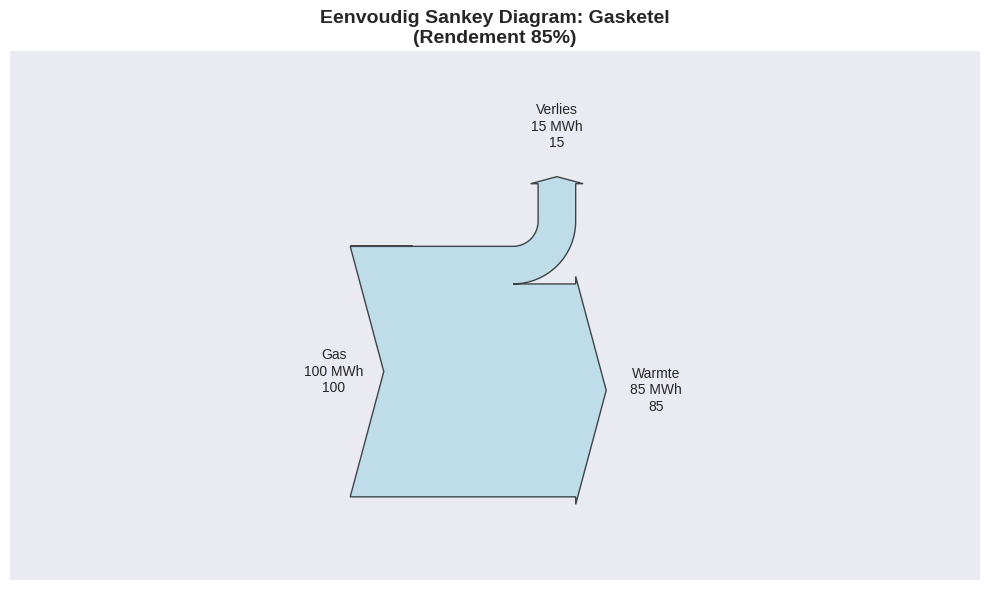


💡 Interpretatie:
   - Breedte pijl = hoeveelheid energie
   - Positieve waarden = input (naar rechts)
   - Negatieve waarden = output (weg van systeem)
   - Totaal moet optellen tot 0 (energiebehoud!)


In [21]:
# Eenvoudig voorbeeld: Gas → Gasketel → Warmte
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, xticks=[], yticks=[])

sankey = Sankey(ax=ax, scale=0.01, offset=0.2, head_angle=150)

# Flows: positief = input, negatief = output
# Gas in → Warmte uit + Verlies
sankey.add(
    flows=[100, -85, -15],  # 100 MWh gas → 85 MWh warmte + 15 MWh verlies
    labels=['Gas\n100 MWh', 'Warmte\n85 MWh', 'Verlies\n15 MWh'],
    orientations=[0, 0, 1],  # Rechts, rechts, naar boven
    facecolor='lightblue',
    edgecolor='black',
    alpha=0.7
)

diagrams = sankey.finish()
plt.title('Eenvoudig Sankey Diagram: Gasketel\n(Rendement 85%)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n💡 Interpretatie:")
print("   - Breedte pijl = hoeveelheid energie")
print("   - Positieve waarden = input (naar rechts)")
print("   - Negatieve waarden = output (weg van systeem)")
print("   - Totaal moet optellen tot 0 (energiebehoud!)")

### 🧪 Oefening: Maak je eigen Sankey

Probeer een `sankey` te maken voor de `warmtestroom` in het gebouw voor 2023.
- Input: Warmte WP en Warmte Gasketel
- Output: Vloerverwarming en luchtgroep en restwarmte (sww en niet bemeterde radiatoren)

**Tip:** De som van alle flows moet 0 zijn!

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


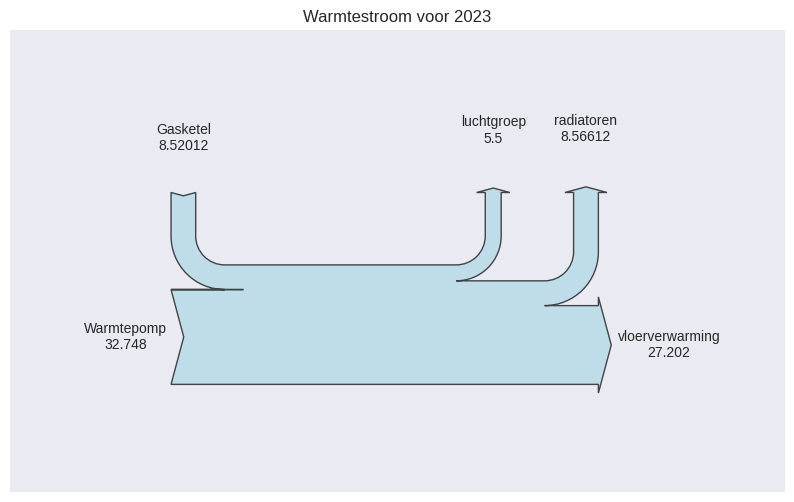

In [22]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, xticks=[], yticks=[])

sankey = Sankey(ax=ax, scale=0.01, offset=0.2, head_angle=150)

gasketel = energie_2023['Gasketel_warmte']
wp = energie_2023['WP_warmte']

vloerverwarming = energie_2023['Vloerverwarming_warm']
luchtgroep = energie_2023['Luchtgroepen_warm']

verschil = (gasketel + wp) - (vloerverwarming + luchtgroep)

sankey.add(
    flows=[gasketel, wp, -vloerverwarming, -luchtgroep, -verschil],
    labels=['Gasketel', 'Warmtepomp', 'vloerverwarming', 'luchtgroep', 'radiatoren'],
    orientations=[1, 0, 0, 1, 1],  # Nu 5 waarden
    facecolor='lightblue',
    edgecolor='black',
    alpha=0.7
)
diagrams = sankey.finish()
plt.title('Warmtestroom voor 2023')
plt.show()

## 6️⃣ Volledig Sankey Diagram: Energiestromen Dunant 1

Nu maken we een volledig Sankey diagram voor het gebouw met:
- **Primaire energie**: Gas + Elektriciteit
- **Conversie**: Gasketel + Warmtepomp
- **Tussenopslag**: BEO-veld
- **Afgifte**: Vloerverwarming, Luchtgroepen, Radiatoren
- **Verliezen**: Rendementverliezen in conversie

### Stap 1: Functie ontwerpen — jaarlijkse energiebalans

Doel: bereken per jaar de belangrijkste energiestromen (input → conversie → opslag → afgifte) om overzichtelijke Sankey-diagrammen te maken.

Wat doet deze functie:
- Neemt een lijst jaren en verschillende dagelijkse tijdreeksen (Pandas DataFrame of Series).
- Aggregreert per jaar de totale energie per categorie en retourneert die totalen als MWh.
- Handelt ontbrekende kolommen veilig af (vult met 0) zodat de functie robuust is voor verschillende datasets.

Inputs:
- years: lijst met jaren (bv. [2022, 2023])
- gasverbruik_kwh: DataFrame/Series met kolom 'gasverbruik' (kWh/dag)
- cal_gasketel_dag, cal_wp_dag, cal_beo_dag, cal_vloer_dag, cal_lucht_dag:
  DataFrames met dagelijkse waarden (kWh/dag). De functie deelt op het einde door 1000 → resultaat in MWh.

Output:
- Dict mapping jaar → dict met keys:
  'Gas', 'Gasketel_warmte', 'WP_warmte',
  'BEO_uit', 'BEO_in',
  'Vloerverwarming_warm', 'Vloerverwarming_koud',
  'Luchtgroepen_warm', 'Luchtgroepen_koud'.

Gebruik:
- Bouw energiebalansen = jaarlijkse_energiebalans(years, gasverbruik_kwh, ...)
- Gebruik energiebalansen[2023] om waarden voor 2023 te halen (in MWh).

In [23]:
def jaarlijkse_energiebalans(years, gasverbruik_kwh, cal_gasketel_dag, cal_inj_dag, cal_wp_dag, cal_beo_dag, cal_vloer_dag, cal_lucht_dag):
    """Bereken jaarlijkse energiebalansen (in MWh)."""
    resultaten = {}
    for year in years:
        mask = lambda df: df.index.year == year
        
        # Bereken basis waarden
        gasketel_warmte = cal_gasketel_dag[mask(cal_gasketel_dag)]['gasketel_warm'].sum() / 1000
        injectie_lt = cal_inj_dag[mask(cal_inj_dag)]['injectie'].sum() / 1000
        
        resultaten[year] = {
            # INPUT (primaire energie)
            'Gas': gasverbruik_kwh[mask(gasverbruik_kwh)]['gasverbruik'].sum() / 1000,

            # CONVERSIE (warmte-opwekking)
            'Gasketel_warmte': gasketel_warmte,
            'Injectie_lt': injectie_lt,  # ✅ TOEGEVOEGD
            'WP_warmte': cal_wp_dag[mask(cal_wp_dag)]['wp_warm'].sum() / 1000,

            # BEO (energieopslag)
            'BEO_uit': cal_beo_dag[mask(cal_beo_dag)]['beo_afname'].sum() / 1000,
            'BEO_in': cal_beo_dag[mask(cal_beo_dag)]['beo_injectie'].sum() / 1000,

            # AFGIFTE (waar gaat warmte naartoe)
            'Vloerverwarming_warm': cal_vloer_dag[mask(cal_vloer_dag)]['vloerverw_warm'].sum() / 1000,
            'Vloerverwarming_koud': cal_vloer_dag[mask(cal_vloer_dag)]['vloerverw_koud'].sum() / 1000,
            'Luchtgroepen_warm': cal_lucht_dag[mask(cal_lucht_dag)]['luchtgroep_warm'].sum(),
            'Luchtgroepen_koud': cal_lucht_dag[mask(cal_lucht_dag)]['luchtgroep_koud'].sum(),
            
            # REST: Radiatoren = gasketel warmte die NIET naar LT-circuit gaat
            'Radiatoren_Lucht': gasketel_warmte - injectie_lt  # ✅ TOEGEVOEGD
        }
    return resultaten

# Gebruik (let op: cal_inj_dag toegevoegd!)
years = [2022, 2023, 2024, 2025]
energiebalansen = jaarlijkse_energiebalans(
    years, gasverbruik_kwh, cal_gasketel_dag, cal_inj_dag, cal_wp_dag, cal_beo_dag, cal_vloer_dag, cal_lucht_dag
)

# Test
print(energiebalansen[2023].keys())

dict_keys(['Gas', 'Gasketel_warmte', 'Injectie_lt', 'WP_warmte', 'BEO_uit', 'BEO_in', 'Vloerverwarming_warm', 'Vloerverwarming_koud', 'Luchtgroepen_warm', 'Luchtgroepen_koud', 'Radiatoren_Lucht'])


### Stap 2: Test de functie voor het jaar 2023

Nu gaan we onze nieuwe functie testen door het Sankey diagram van 2023 opnieuw te maken, maar nu met data uit de functie.

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


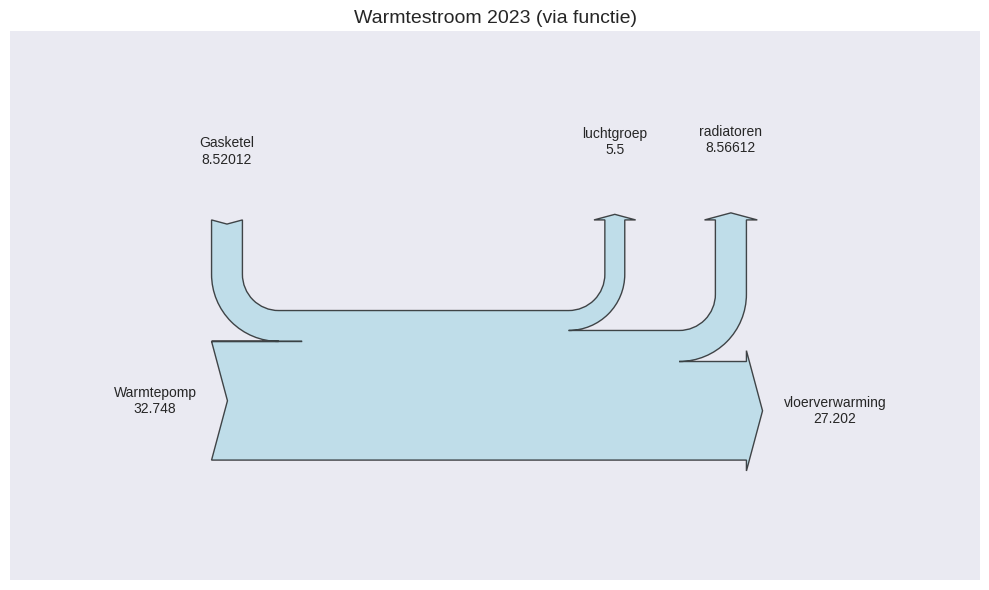

✓ Sankey diagram voor 2023 gemaakt met functie-data
   Controle: Gasketel = 8.5 MWh, WP = 32.7 MWh


In [24]:
# Haal de energie-data voor 2023 op uit onze functie
energie_2023_functie = energiebalansen[2023]

# Maak het Sankey diagram (zelfde code als eerder)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, xticks=[], yticks=[])
sankey = Sankey(ax=ax, scale=0.01, offset=0.2, head_angle=150)

gasketel = energie_2023_functie['Gasketel_warmte']
wp = energie_2023_functie['WP_warmte']
vloerverwarming = energie_2023_functie['Vloerverwarming_warm']
luchtgroep = energie_2023_functie['Luchtgroepen_warm']
verschil = (gasketel + wp) - (vloerverwarming + luchtgroep)

sankey.add(
    flows=[gasketel, wp, -vloerverwarming, -luchtgroep, -verschil],
    labels=['Gasketel', 'Warmtepomp', 'vloerverwarming', 'luchtgroep', 'radiatoren'],
    orientations=[1, 0, 0, 1, 1],
    facecolor='lightblue',
    edgecolor='black',
    alpha=0.7
)
sankey.finish()
plt.title('Warmtestroom 2023 (via functie)', fontsize=14)
plt.tight_layout()
plt.show()

print(f"✓ Sankey diagram voor 2023 gemaakt met functie-data")
print(f"   Controle: Gasketel = {gasketel:.1f} MWh, WP = {wp:.1f} MWh")

### Stap 3: Sankey voor alle jaren tegelijk

Nu we weten dat onze functie werkt, kunnen we eenvoudig `Sankey` diagrammen maken voor **alle jaren** in één keer!

**Voordeel**: We zien meteen trends over de jaren heen (Bijv. verminderd gasverbruik, toegenomen WP-gebruik).

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


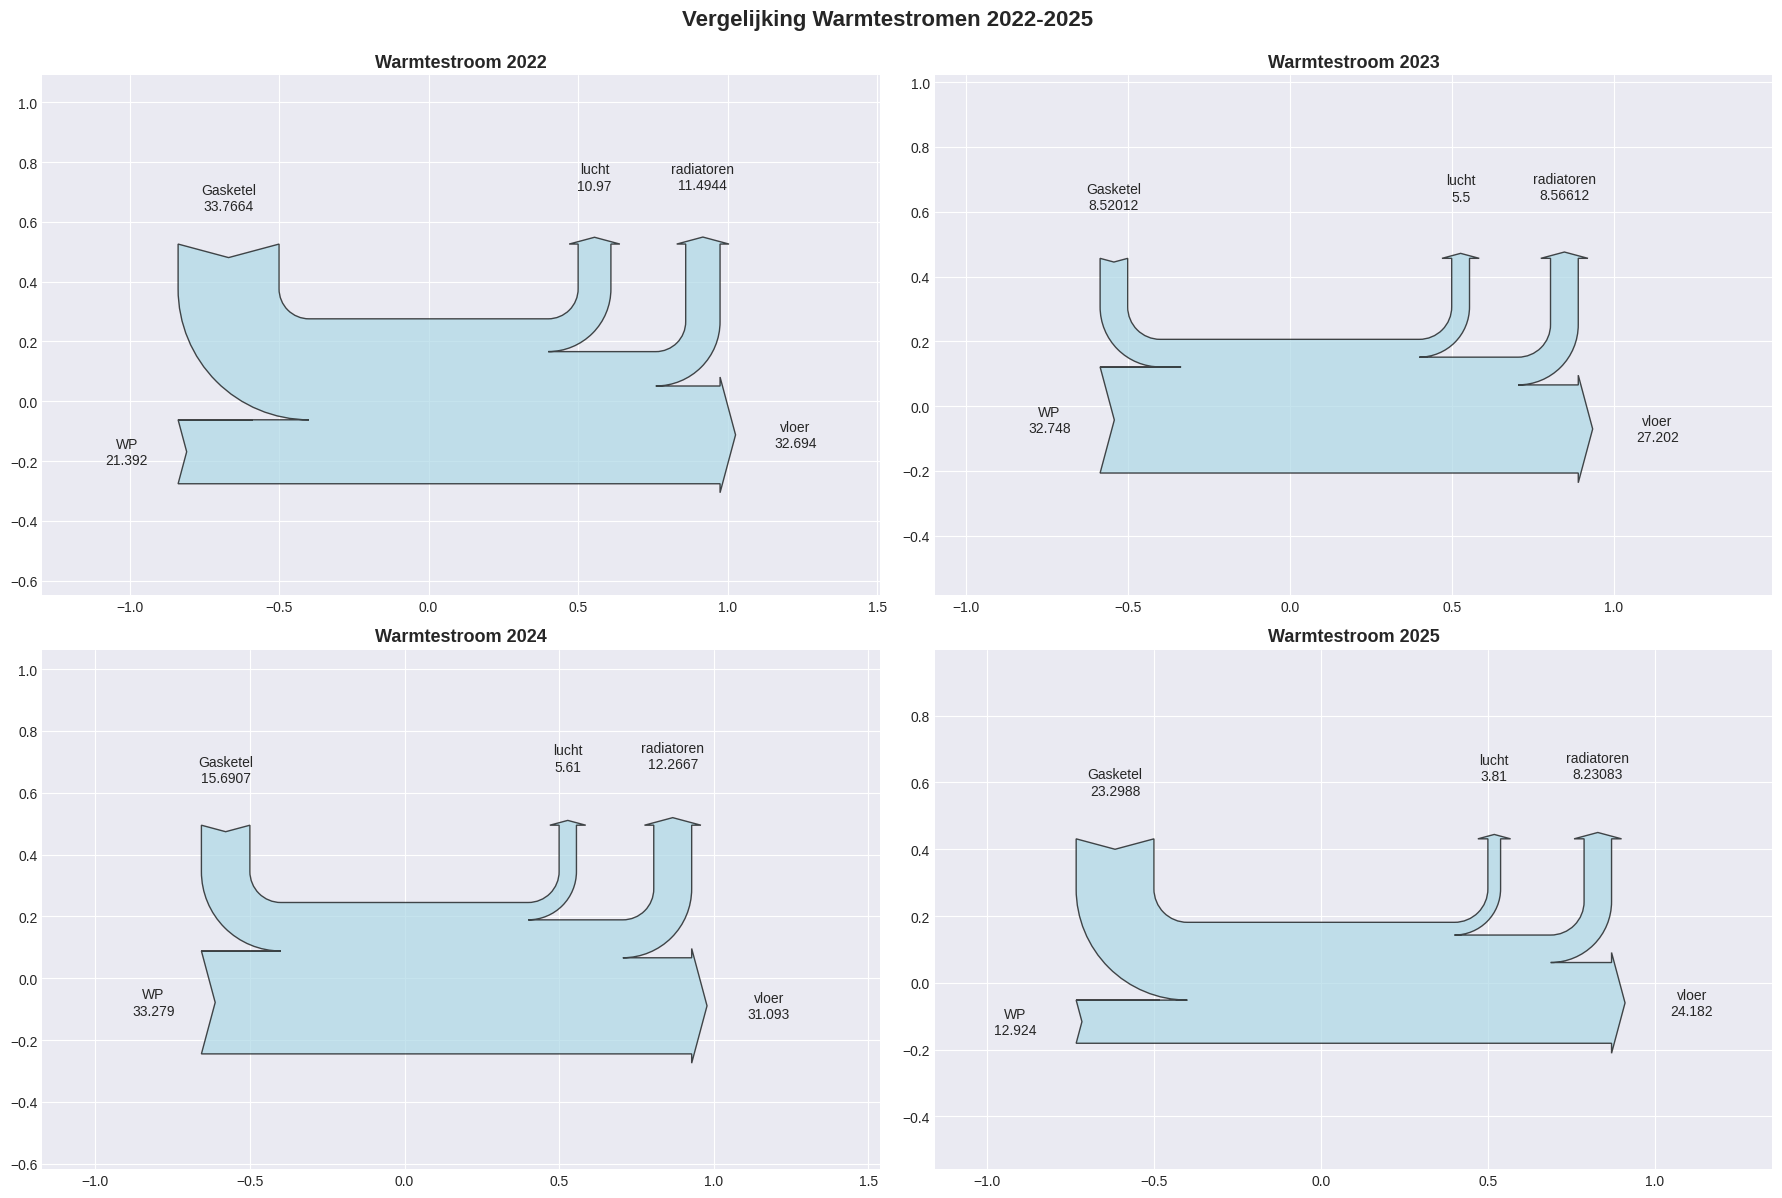

✓ Sankey diagrammen voor 4 jaren gemaakt


In [25]:
# Maak een grid van 2x2 subplots (4 jaren)
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()  # Omzetten naar 1D array voor makkelijk indexeren

for idx, year in enumerate(years):
    # Haal data op voor dit jaar
    energie = energiebalansen[year]
    gasketel = energie['Gasketel_warmte']
    wp = energie['WP_warmte']
    vloerverwarming = energie['Vloerverwarming_warm']
    luchtgroep = energie['Luchtgroepen_warm']
    verschil = (gasketel + wp) - (vloerverwarming + luchtgroep)
    
    # Maak Sankey in deze subplot
    ax = axes[idx]
    sankey = Sankey(ax=ax, scale=0.01, offset=0.2, head_angle=150)
    sankey.add(
        flows=[gasketel, wp, -vloerverwarming, -luchtgroep, -verschil],
        labels=['Gasketel', 'WP', 'vloer', 'lucht', 'radiatoren'],
        orientations=[1, 0, 0, 1, 1],
        facecolor='lightblue',
        edgecolor='black',
        alpha=0.7
    )
    sankey.finish()
    ax.set_title(f'Warmtestroom {year}', fontsize=13, fontweight='bold')

# Verwijder lege subplots (als er minder dan 4 jaren zijn)
for j in range(len(years), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Vergelijking Warmtestromen 2022-2025', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print(f"✓ Sankey diagrammen voor {len(years)} jaren gemaakt")

### 💡 Reflectievragen

- Zie je een trend in de opwekking over de jaren?
- Zie je een trend in de afgifte over de jaren?
- Welke informatie zou je nog kunnen toevoegen om de trends beter te analyseren?

### Stap 4: Volledige systeem

Tot nu toe hebben we alleen de **warmte-output** (gasketel + WP) naar de afgiftesystemen gevisualiseerd.

Maar nu gaan we het **volledige systeem** in kaart brengen

```PlainText
GAS → GASKETEL → WARMTE 
                    ↓
              DISTRIBUTIE → VLOER + LUCHT + REST
                    ↑
BEO ← WARMTEPOMP ← ELEKTRICITEIT
```

Dit is complexer omdat we **meerdere Sankey-lagen** na elkaar moeten koppelen.

#### 💭 Begrijp je nu de volledige keten?

Gas → Gasketel → Warmte → Distributie → Gebouw  
Elektriciteit → WP (+ BEO) → Warmte → Distributie → Gebouw

#### Vereenvoudig volledig Sankey (zonder BEO detail)

We beginnen met een **versimpelde versie** zonder BEO-details, om de basis te leggen:

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


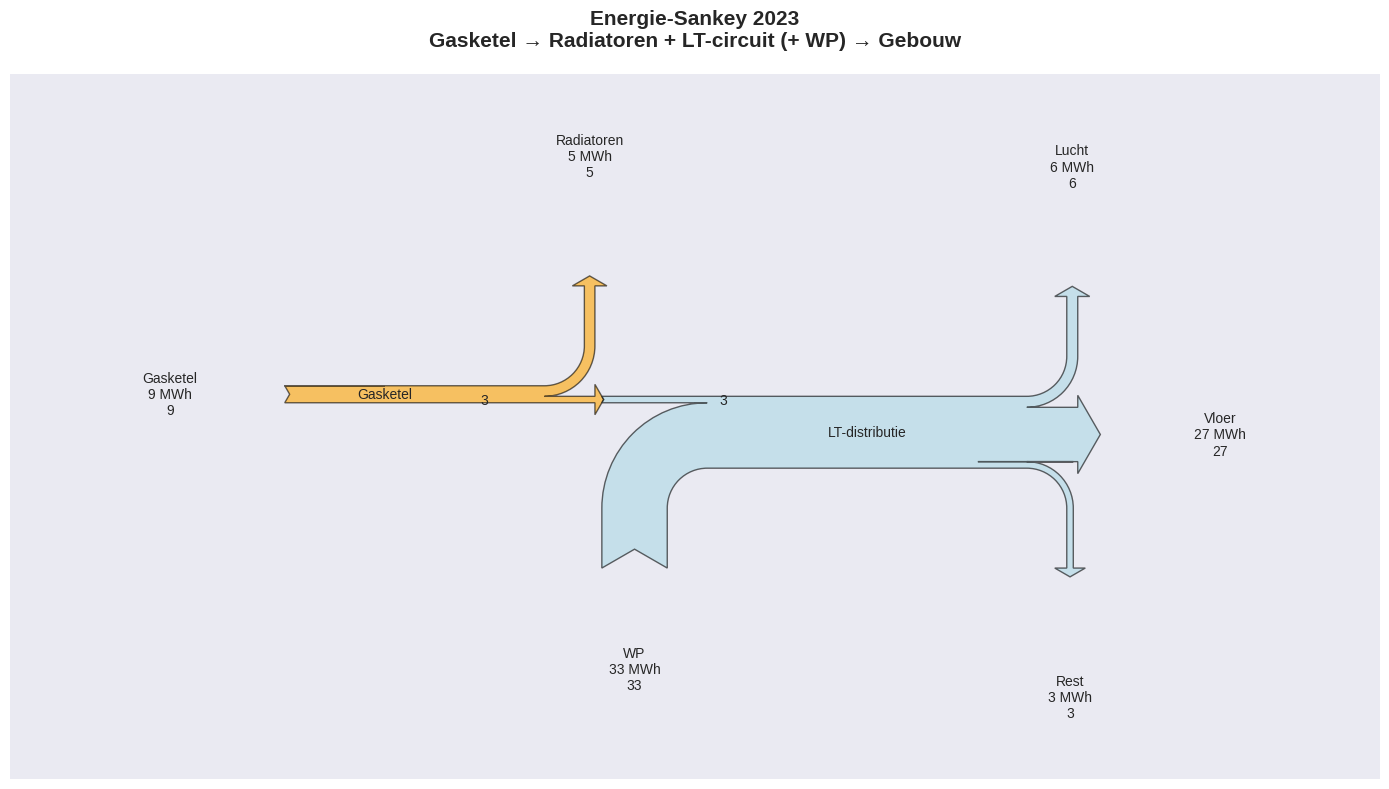

✓ Volledig Sankey diagram gemaakt

📊 Controle:
  Gasketel productie: 8.5 MWh
    → Naar LT-circuit: 3.2 MWh
    → Direct radiatoren: 5.3 MWh
  LT-circuit totaal (injectie + WP): 36.0 MWh
    → Vloer: 27.2 MWh
    → Lucht: 5.5 MWh
    → Rest: 3.3 MWh


In [26]:
# Data voor 2023
e = energie_2023.copy()

# Bereken de stromen
gasketel_warmte = e['Gasketel_warmte']
wp_warmte = e['WP_warmte']
injectie = e['Injectie_lt']
radiatoren = e['Radiatoren_Lucht']

vloer = e['Vloerverwarming_warm']
lucht = e['Luchtgroepen_warm']

# BELANGRIJK: Bereken wat er overblijft voor niet-bemeterde systemen
# (verschil tussen injectie + WP warmte en gemeten afgifte)
rest = (injectie + wp_warmte) - (vloer + lucht)

# Maak diagram
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(1, 1, 1, xticks=[], yticks=[])

sankey = Sankey(ax=ax, scale=0.005, offset=0.3, head_angle=120, format='%.0f')

# LAAG 1: Gasketel → splits naar LT-circuit en radiatoren
sankey.add(
    flows=[gasketel_warmte, -injectie, -radiatoren],
    labels=[f'Gasketel\n{gasketel_warmte:.0f} MWh', '', f'Radiatoren\n{radiatoren:.0f} MWh'],
    orientations=[0, 0, 1],  # Gasketel rechts, injectie rechts, radiatoren omhoog
    facecolor='orange',
    alpha=0.6,
    patchlabel='Gasketel'
)

# LAAG 2: LT-distributie → vloer + lucht + rest
sankey.add(
    flows=[injectie, wp_warmte, -vloer, -lucht, -rest],  # ✅ Gebruik 'injectie' ipv 'gasketel_warmte'
    labels=['', f'WP\n{wp_warmte:.0f} MWh', f'Vloer\n{vloer:.0f} MWh', 
            f'Lucht\n{lucht:.0f} MWh', f'Rest\n{rest:.0f} MWh'],
    orientations=[0, -1, 0, 1, -1],
    prior=0,  # Koppel aan eerste diagram
    connect=(1, 0),  # Output 1 (injectie) van diagram 0 → input 0 van dit diagram
    facecolor='lightblue',
    alpha=0.6,
    patchlabel='LT-distributie'
)

diagrams = sankey.finish()

plt.title('Energie-Sankey 2023\nGasketel → Radiatoren + LT-circuit (+ WP) → Gebouw', 
          fontsize=15, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("✓ Volledig Sankey diagram gemaakt")
print(f"\n📊 Controle:")
print(f"  Gasketel productie: {gasketel_warmte:.1f} MWh")
print(f"    → Naar LT-circuit: {injectie:.1f} MWh")
print(f"    → Direct radiatoren: {radiatoren:.1f} MWh")
print(f"  LT-circuit totaal (injectie + WP): {injectie + wp_warmte:.1f} MWh")
print(f"    → Vloer: {vloer:.1f} MWh")
print(f"    → Lucht: {lucht:.1f} MWh")
print(f"    → Rest: {rest:.1f} MWh")

## 7️⃣ Interactief Sankey Diagram met Plotly

Matplotlib Sankey diagrammen zijn statisch. Voor **interactieve rapportage** gebruiken we **Plotly**, waarmee je:
- Over stromen kunt hoveren voor details
- Kunt inzoomen en pannen
- Makkelijk kunt exporteren naar HTML

In [29]:
%pip install nbformat>=4.2.0


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [28]:
# Plotly Sankey: Start vanuit warmte-opwekking (niet primair gas)
e = energie_2023.copy()

# Bereken stromen
gasketel_warmte = e['Gasketel_warmte']
injectie = e['Injectie_lt']
radiatoren = e['Radiatoren_Lucht']
wp_warmte = e['WP_warmte']
vloer = e['Vloerverwarming_warm']
lucht = e['Luchtgroepen_warm']
rest = (injectie + wp_warmte) - (vloer + lucht)

# Definieer nodes (0-indexed) - NU ZONDER GAS INPUT
nodes = [
    "Gasketel",            # 0 - START HIER
    "Warmtepomp",          # 1 - START HIER
    "Injectie LT",         # 2
    "Radiatoren & NVWB",   # 3
    "LT-Distributie",      # 4
    "Vloerverwarming",     # 5
    "Luchtgroepen",        # 6
    "Rest (SWW, etc.)"     # 7
]

# Definieer links (bron → bestemming, waarde)
links = {
    'source': [
        0,  # Gasketel → Injectie LT
        0,  # Gasketel → Radiatoren
        2,  # Injectie LT → LT-Distributie
        1,  # WP → LT-Distributie
        4,  # LT-Distributie → Vloer
        4,  # LT-Distributie → Lucht
        4   # LT-Distributie → Rest
    ],
    'target': [
        2,  # → Injectie LT
        3,  # → Radiatoren
        4,  # → LT-Distributie
        4,  # → LT-Distributie
        5,  # → Vloer
        6,  # → Lucht
        7   # → Rest
    ],
    'value': [
        injectie,
        radiatoren,
        injectie,
        wp_warmte,
        vloer,
        lucht,
        rest
    ],
    'label': [
        f"{injectie:.0f} MWh",
        f"{radiatoren:.0f} MWh",
        f"{injectie:.0f} MWh",
        f"{wp_warmte:.0f} MWh",
        f"{vloer:.0f} MWh",
        f"{lucht:.0f} MWh",
        f"{rest:.0f} MWh"
    ]
}

# Maak Plotly Sankey
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=20,
        thickness=25,
        line=dict(color="black", width=0.5),
        label=[
            f"Gasketel<br>{gasketel_warmte:.0f} MWh",
            f"Warmtepomp<br>{wp_warmte:.0f} MWh",
            "Injectie LT",
            "Radiatoren & NVWB",
            "LT-Distributie",
            "Vloerverwarming",
            "Luchtgroepen",
            "Rest (SWW, etc.)"
        ],
        color=[
            "orange",      # Gasketel
            "blue",        # WP
            "darkorange",  # Injectie LT
            "brown",       # Radiatoren
            "lightblue",   # LT-Distributie
            "lightgreen",  # Vloer
            "lightgreen",  # Lucht
            "lightgray"    # Rest
        ]
    ),
    link=dict(
        source=links['source'],
        target=links['target'],
        value=links['value'],
        label=links['label'],
        color=[
            "rgba(255,165,0,0.4)",   # Gasketel → Injectie
            "rgba(165,42,42,0.4)",   # Gasketel → Radiatoren
            "rgba(255,140,0,0.4)",   # Injectie → Distributie
            "rgba(0,0,255,0.4)",     # WP → Distributie
            "rgba(144,238,144,0.4)", # Distributie → Vloer
            "rgba(144,238,144,0.4)", # Distributie → Lucht
            "rgba(211,211,211,0.4)"  # Distributie → Rest
        ]
    )
)])

fig.update_layout(
    title="Interactief Energie-Sankey 2023<br><sub>Warmte-opwekking → Distributie → Afgifte</sub>",
    font=dict(size=12),
    height=700,
    plot_bgcolor='white'
)

fig.show()

print("✓ Interactief Plotly Sankey gemaakt (start vanuit warmte-opwekking)")
print(f"\n📊 Stroomoverzicht:")
print(f"  🔥 Gasketel ({gasketel_warmte:.1f} MWh):")
print(f"     → Injectie LT: {injectie:.1f} MWh")
print(f"     → Radiatoren: {radiatoren:.0f} MWh")
print(f"\n  ❄️  Warmtepomp ({wp_warmte:.1f} MWh):")
print(f"     → Direct naar LT-Distributie")
print(f"\n  🏠 LT-circuit ({injectie + wp_warmte:.1f} MWh):")
print(f"     → Vloer: {vloer:.1f} MWh")
print(f"     → Lucht: {lucht:.0f} MWh")
print(f"     → Rest: {rest:.1f} MWh")

✓ Interactief Plotly Sankey gemaakt (start vanuit warmte-opwekking)

📊 Stroomoverzicht:
  🔥 Gasketel (8.5 MWh):
     → Injectie LT: 3.2 MWh
     → Radiatoren: 5 MWh

  ❄️  Warmtepomp (32.7 MWh):
     → Direct naar LT-Distributie

  🏠 LT-circuit (36.0 MWh):
     → Vloer: 27.2 MWh
     → Lucht: 6 MWh
     → Rest: 3.3 MWh


> 💡 **TIP!**: Bewaar je diagram als HTML om te delen met anderen.

In [ ]:
fig.write_html("sankey_2023.html")

## 8️⃣ Tijdsafhankelijke Analyse: Maandelijkse Energiestromen

Tot nu toe hebben we jaarlijkse totalen gebruikt. Maar hoe **varieert** de energiestroom doorheen het jaar? Laten we maandelijkse data visualiseren.

### 🎨 Interactieve Maandelijkse Sankey (Bonus)

Voor een nog beter inzicht kunnen we een **dropdown menu** toevoegen om per maand het Sankey diagram te tonen.

In [30]:
# 🎨 Interactieve Sankey voor alle jaren
figures = []

for year in years:
    e = energiebalansen[year]
    
    # Bereken stromen voor dit jaar
    gasketel_warmte = e['Gasketel_warmte']
    injectie = e['Injectie_lt']
    radiatoren = e['Radiatoren_Lucht']
    wp_warmte = e['WP_warmte']
    vloer = e['Vloerverwarming_warm']
    lucht = e['Luchtgroepen_warm']
    rest = (injectie + wp_warmte) - (vloer + lucht)
    
    # Definieer nodes (zelfde voor elk jaar)
    nodes = [
        "Gasketel",
        "Warmtepomp",
        "Injectie LT",
        "Radiatoren & NVWB",
        "LT-Distributie",
        "Vloerverwarming",
        "Luchtgroepen",
        "Rest (SWW, etc.)"
    ]
    
    # Definieer links met DATA VAN DIT JAAR
    links = {
        'source': [0, 0, 2, 1, 4, 4, 4],
        'target': [2, 3, 4, 4, 5, 6, 7],
        'value': [injectie, radiatoren, injectie, wp_warmte, vloer, lucht, rest],
        'label': [
            f"{injectie:.0f} MWh",
            f"{radiatoren:.0f} MWh",
            f"{injectie:.0f} MWh",
            f"{wp_warmte:.0f} MWh",
            f"{vloer:.0f} MWh",
            f"{lucht:.0f} MWh",
            f"{rest:.0f} MWh"
        ]
    }
    
    # Maak figuur voor dit jaar
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=20,
            thickness=25,
            line=dict(color="black", width=0.5),
            label=[
                f"Gasketel<br>{gasketel_warmte:.0f} MWh",
                f"Warmtepomp<br>{wp_warmte:.0f} MWh",
                "Injectie LT",
                "Radiatoren & NVWB",
                "LT-Distributie",
                "Vloerverwarming",
                "Luchtgroepen",
                "Rest (SWW, etc.)"
            ],
            color=["orange", "blue", "darkorange", "brown", "lightblue", 
                   "lightgreen", "lightgreen", "lightgray"]
        ),
        link=dict(
            source=links['source'],
            target=links['target'],
            value=links['value'],
            label=links['label'],
            color=[
                "rgba(255,165,0,0.4)",   # Gasketel → Injectie
                "rgba(165,42,42,0.4)",   # Gasketel → Radiatoren
                "rgba(255,140,0,0.4)",   # Injectie → Distributie
                "rgba(0,0,255,0.4)",     # WP → Distributie
                "rgba(144,238,144,0.4)", # Distributie → Vloer
                "rgba(144,238,144,0.4)", # Distributie → Lucht
                "rgba(211,211,211,0.4)"  # Distributie → Rest
            ]
        )
    )])
    
    fig.update_layout(
        title=f"Energie-Sankey {year}<br><sub>Warmte-opwekking → Distributie → Afgifte</sub>",
        font=dict(size=12),
        height=700,
        plot_bgcolor='white'
    )
    
    figures.append(fig)

# Toon alle figuren na elkaar
for idx, fig in enumerate(figures):
    print(f"\n📊 Sankey diagram voor {years[idx]}")
    fig.show()

print(f"\n✓ {len(figures)} interactieve Sankey diagrammen gemaakt voor jaren {years}")


📊 Sankey diagram voor 2022



📊 Sankey diagram voor 2023



📊 Sankey diagram voor 2024



📊 Sankey diagram voor 2025



✓ 4 interactieve Sankey diagrammen gemaakt voor jaren [2022, 2023, 2024, 2025]


## 🎓 Samenvatting: Wat heb je geleerd?

In deze oefening heb je geleerd om:

1. **Sankey diagrammen maken** met Matplotlib en Plotly
2. **Energiestromen structureren** van input → conversie → opslag → distributie → afgifte
3. **Energiebalansen opstellen** en verliezen identificeren
4. **Rendementen visualiseren** op systeem- en componentniveau
5. **Tijdsafhankelijke patronen** analyseren (maandelijks, jaarlijks)
6. **Interactieve visualisaties** maken voor rapportage
7. **Data-gedreven aanbevelingen** formuleren

### 🔧 Herbruikbare Skills

De technieken die je hier hebt geleerd zijn direct toepasbaar op:
- Andere gebouwen met HVAC-systemen
- Industriële processen (energie, water, materiaalstromen)
- Financiële stromen (cash flow, budgetanalyse)
- Elke situatie waar je **stromen tussen knooppunten** wilt visualiseren

### 📚 Volgende Stappen

Experimenteer verder door:
- Andere jaren te analyseren (2020-2023)
- Vergelijkingen te maken tussen jaren
- Weekpatronen te onderzoeken (werkdag vs weekend)
- Correlaties met buitentemperatuur te visualiseren

---

**💪 Goed gedaan!** Je hebt nu een krachtige toolbox voor energiestromen-analyse.

-----
EINDE

---